In [1]:
!unzip Brain_tumor_dataset.zip -d Brain_tumor_dataset

Streaming output truncated to the last 5000 lines.
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: Brain_tumor_dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: Brain_tumor_

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers,models,regularizers
from tensorflow.keras.metrics import Precision, Recall

In [3]:
Image_size=(224,224)
batch_size=32
#Data preprocessing
image_size = (224, 224)
batch_size = 32
train_data="/content/Brain_tumor_dataset/Training"
test_data="/content/Brain_tumor_dataset/Testing"
val_split=0.2
seed=42
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=val_split,
    shear_range=0.1,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    brightness_range=[0.9, 1.5]

)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=val_split
)

train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    train_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:
def vgg16():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(224,224,3)))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))

    # Block 2
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))

    # Block 3
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))

    # Block 4
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))

    # Block 5
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    return model


In [5]:
model=vgg16()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,824,964 (106.14 MB)

 Trainable params: 27,824,964 (106.14 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy','precision','recall'])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]


In [8]:
history=model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=callbacks,verbose=1)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.3714 - loss: 1.2567 - precision: 0.5539 - recall: 0.1012

143/143 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.3721 - loss: 1.2557 - precision: 0.5549 - recall: 0.1020 - val_accuracy: 0.5372 - val_loss: 1.0430 - val_precision: 0.6372 - val_recall: 0.4479 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 652ms/step - accuracy: 0.6422 - loss: 0.7926 - precision: 0.7252 - recall: 0.5138 - val_accuracy: 0.5855 - val_loss: 1.1069 - val_precision: 0.6470 - val_recall: 0.4996 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7013 - loss: 0.6978 - precision: 0.7750 - recall: 0.5905

143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 693ms/step - accuracy: 0.7014 - loss: 0.6975 - precision: 0.7750 - recall: 0.5908 - val_accuracy: 0.7029 - val_loss: 0.7816 - val_precision: 0.7279 - val_recall: 0.6424 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.7406 - loss: 0.6113 - precision: 0.7752 - recall: 0.6796

143/143 ━━━━━━━━━━━━━━━━━━━━ 98s 687ms/step - accuracy: 0.7407 - loss: 0.6111 - precision: 0.7753 - recall: 0.6797 - val_accuracy: 0.6792 - val_loss: 0.7773 - val_precision: 0.7438 - val_recall: 0.6030 - learning_rate: 1.0000e-04
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 649ms/step - accuracy: 0.7642 - loss: 0.5814 - precision: 0.8027 - recall: 0.7081 - val_accuracy: 0.6494 - val_loss: 0.8977 - val_precision: 0.6799 - val_recall: 0.6293 - learning_rate: 1.0000e-04
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.7814 - loss: 0.5354 - precision: 0.8126 - recall: 0.7378

143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 689ms/step - accuracy: 0.7815 - loss: 0.5352 - precision: 0.8127 - recall: 0.7379 - val_accuracy: 0.7537 - val_loss: 0.7527 - val_precision: 0.7703 - val_recall: 0.7406 - learning_rate: 1.0000e-04
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8166 - loss: 0.4497 - precision: 0.8401 - recall: 0.7927

143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 696ms/step - accuracy: 0.8166 - loss: 0.4497 - precision: 0.8401 - recall: 0.7927 - val_accuracy: 0.7379 - val_loss: 0.7478 - val_precision: 0.7559 - val_recall: 0.7003 - learning_rate: 1.0000e-04
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.8218 - loss: 0.4169 - precision: 0.8399 - recall: 0.7961

143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 687ms/step - accuracy: 0.8218 - loss: 0.4168 - precision: 0.8400 - recall: 0.7963 - val_accuracy: 0.7651 - val_loss: 0.6223 - val_precision: 0.7870 - val_recall: 0.7511 - learning_rate: 1.0000e-04
Epoch 9/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 666ms/step - accuracy: 0.8347 - loss: 0.4129 - precision: 0.8534 - recall: 0.8193 - val_accuracy: 0.7467 - val_loss: 0.7143 - val_precision: 0.7616 - val_recall: 0.7309 - learning_rate: 1.0000e-04
Epoch 10/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 141s 656ms/step - accuracy: 0.8506 - loss: 0.3819 - precision: 0.8630 - recall: 0.8366 - val_accuracy: 0.7362 - val_loss: 0.7858 - val_precision: 0.7534 - val_recall: 0.7257 - learning_rate: 1.0000e-04
Epoch 11/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8469 - loss: 0.3749 - precision: 0.8594 - recall: 0.8301

143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 695ms/step - accuracy: 0.8469 - loss: 0.3749 - precision: 0.8595 - recall: 0.8301 - val_accuracy: 0.8011 - val_loss: 0.5930 - val_precision: 0.8134 - val_recall: 0.7756 - learning_rate: 1.0000e-04
Epoch 12/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 651ms/step - accuracy: 0.8703 - loss: 0.3424 - precision: 0.8824 - recall: 0.8585 - val_accuracy: 0.7756 - val_loss: 0.6136 - val_precision: 0.7967 - val_recall: 0.7590 - learning_rate: 1.0000e-04
Epoch 13/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8761 - loss: 0.3258 - precision: 0.8884 - recall: 0.8611

143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 692ms/step - accuracy: 0.8761 - loss: 0.3258 - precision: 0.8884 - recall: 0.8612 - val_accuracy: 0.7826 - val_loss: 0.5927 - val_precision: 0.7976 - val_recall: 0.7634 - learning_rate: 1.0000e-04
Epoch 14/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8855 - loss: 0.3045 - precision: 0.8911 - recall: 0.8782

143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 700ms/step - accuracy: 0.8855 - loss: 0.3045 - precision: 0.8911 - recall: 0.8782 - val_accuracy: 0.7888 - val_loss: 0.5732 - val_precision: 0.8002 - val_recall: 0.7756 - learning_rate: 1.0000e-04
Epoch 15/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 648ms/step - accuracy: 0.8846 - loss: 0.3022 - precision: 0.8955 - recall: 0.8757 - val_accuracy: 0.7984 - val_loss: 0.6500 - val_precision: 0.8156 - val_recall: 0.7905 - learning_rate: 1.0000e-04
Epoch 16/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8914 - loss: 0.2976 - precision: 0.8992 - recall: 0.8835

143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 694ms/step - accuracy: 0.8914 - loss: 0.2975 - precision: 0.8992 - recall: 0.8835 - val_accuracy: 0.8151 - val_loss: 0.5301 - val_precision: 0.8239 - val_recall: 0.8081 - learning_rate: 1.0000e-04
Epoch 17/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 103s 717ms/step - accuracy: 0.9007 - loss: 0.2661 - precision: 0.9077 - recall: 0.8927 - val_accuracy: 0.8072 - val_loss: 0.5807 - val_precision: 0.8212 - val_recall: 0.7932 - learning_rate: 1.0000e-04
Epoch 18/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 103s 721ms/step - accuracy: 0.9100 - loss: 0.2434 - precision: 0.9156 - recall: 0.9031 - val_accuracy: 0.8300 - val_loss: 0.5536 - val_precision: 0.8378 - val_recall: 0.8195 - learning_rate: 1.0000e-04
Epoch 19/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 661ms/step - accuracy: 0.9161 - loss: 0.2242 - precision: 0.9225 - recall: 0.9100 - val_accuracy: 0.7932 - val_loss: 0.7052 - val_precision: 0.7984 - val_recall: 0.7774 - learning_rate: 1.0000e-04
Epoch 20/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0

143/143 ━━━━━━━━━━━━━━━━━━━━ 106s 738ms/step - accuracy: 0.9280 - loss: 0.2035 - precision: 0.9325 - recall: 0.9220 - val_accuracy: 0.8422 - val_loss: 0.4489 - val_precision: 0.8488 - val_recall: 0.8361 - learning_rate: 2.0000e-05
Epoch 21/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.9488 - loss: 0.1390 - precision: 0.9550 - recall: 0.9470

143/143 ━━━━━━━━━━━━━━━━━━━━ 118s 816ms/step - accuracy: 0.9488 - loss: 0.1390 - precision: 0.9550 - recall: 0.9470 - val_accuracy: 0.8659 - val_loss: 0.4293 - val_precision: 0.8716 - val_recall: 0.8624 - learning_rate: 2.0000e-05
Epoch 22/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9468 - loss: 0.1316 - precision: 0.9499 - recall: 0.9445

143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 665ms/step - accuracy: 0.9468 - loss: 0.1316 - precision: 0.9499 - recall: 0.9445 - val_accuracy: 0.8633 - val_loss: 0.4158 - val_precision: 0.8692 - val_recall: 0.8563 - learning_rate: 2.0000e-05
Epoch 23/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.9507 - loss: 0.1361 - precision: 0.9537 - recall: 0.9469

143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 674ms/step - accuracy: 0.9507 - loss: 0.1361 - precision: 0.9537 - recall: 0.9469 - val_accuracy: 0.8764 - val_loss: 0.3720 - val_precision: 0.8826 - val_recall: 0.8694 - learning_rate: 2.0000e-05
Epoch 24/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 645ms/step - accuracy: 0.9604 - loss: 0.1186 - precision: 0.9633 - recall: 0.9593 - val_accuracy: 0.8677 - val_loss: 0.3765 - val_precision: 0.8727 - val_recall: 0.8650 - learning_rate: 2.0000e-05
Epoch 25/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 648ms/step - accuracy: 0.9512 - loss: 0.1213 - precision: 0.9536 - recall: 0.9485 - val_accuracy: 0.8615 - val_loss: 0.4099 - val_precision: 0.8655 - val_recall: 0.8571 - learning_rate: 2.0000e-05
Epoch 26/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 649ms/step - accuracy: 0.9522 - loss: 0.1264 - precision: 0.9557 - recall: 0.9507 - val_accuracy: 0.8598 - val_loss: 0.4629 - val_precision: 0.8684 - val_recall: 0.8563 - learning_rate: 2.0000e-05
Epoch 27/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 

143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 700ms/step - accuracy: 0.9629 - loss: 0.1034 - precision: 0.9652 - recall: 0.9578 - val_accuracy: 0.8887 - val_loss: 0.3572 - val_precision: 0.8913 - val_recall: 0.8843 - learning_rate: 4.0000e-06
Epoch 28/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 650ms/step - accuracy: 0.9646 - loss: 0.0966 - precision: 0.9658 - recall: 0.9630 - val_accuracy: 0.8834 - val_loss: 0.3870 - val_precision: 0.8885 - val_recall: 0.8799 - learning_rate: 4.0000e-06
Epoch 29/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 650ms/step - accuracy: 0.9610 - loss: 0.1070 - precision: 0.9623 - recall: 0.9574 - val_accuracy: 0.8799 - val_loss: 0.3938 - val_precision: 0.8857 - val_recall: 0.8764 - learning_rate: 4.0000e-06
Epoch 30/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 649ms/step - accuracy: 0.9650 - loss: 0.0885 - precision: 0.9668 - recall: 0.9639 - val_accuracy: 0.8861 - val_loss: 0.3620 - val_precision: 0.8917 - val_recall: 0.8799 - learning_rate: 4.0000e-06
Epoch 31/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 93

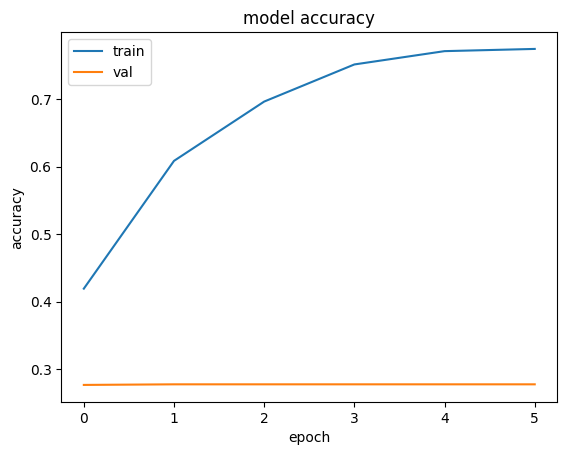

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

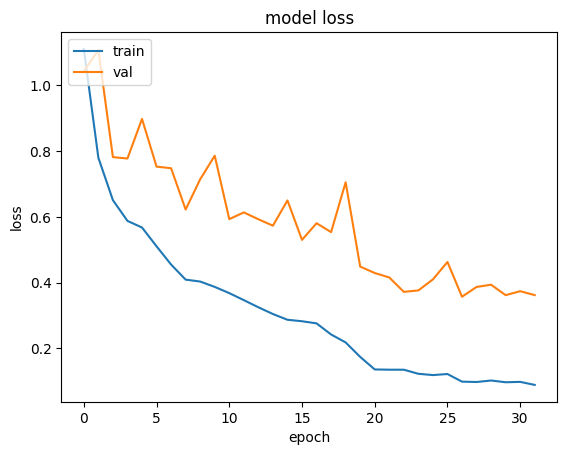

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()

In [11]:
evaluation_results = model.evaluate(test_generator)
test_loss = evaluation_results[0]
test_acc = evaluation_results[1]
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 508ms/step - accuracy: 0.8831 - loss: 0.3098 - precision: 0.8894 - recall: 0.8812
Test Accuracy: 0.9176201224327087
Test Loss: 0.22517073154449463


In [12]:
pred_probs = model.predict(test_generator)


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step


In [13]:
pred_classes = np.argmax(pred_probs, axis=1)
print(pred_classes)
print(pred_classes.shape)


[0 0 0 ... 3 3 3]
(1311,)


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(true_classes, pred_classes, target_names=class_labels))


              precision    recall  f1-score   support

      glioma       0.94      0.92      0.93       300
  meningioma       0.91      0.75      0.83       306
     notumor       0.91      1.00      0.95       405
   pituitary       0.91      0.97      0.94       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



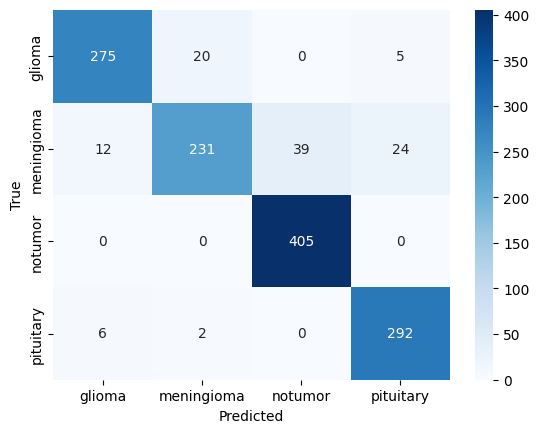

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Using Transfer Learning for VGG16

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [17]:
# 1. Load VGG16 without the top FC layers
base_model = VGG16(
    weights='imagenet',        # 🔥 this is transfer learning
    include_top=False,         # remove original 4096-4096-1000 classifier
    input_shape=(224, 224, 3)
)
print(len(base_model.layers))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
19


In [18]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Freeze all convolutional layers for now
for layer in base_model.layers:
    layer.trainable = False

# Adding  own classifier head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [20]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy','precision','recall']
)

model.summary()


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 264,708 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    brightness_range=[0.9, 1.5],
    shear_range=0.2,
    rescale=1./255

)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    '/content/Brain_tumor_dataset/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    '/content/Brain_tumor_dataset/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [22]:
callbacks = [


    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),


    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    ),


    ModelCheckpoint(
        filepath="best_vgg16_tumor.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )



]


In [23]:
history1=model.fit(train_gen, epochs=50, validation_data=val_gen, callbacks=callbacks,verbose=1)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.3336 - loss: 1.4552 - precision: 0.4335 - recall: 0.0646
Epoch 1: val_loss improved from inf to 10.64010, saving model to best_vgg16_tumor.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 636ms/step - accuracy: 0.3342 - loss: 1.4544 - precision: 0.4348 - recall: 0.0648 - val_accuracy: 0.2770 - val_loss: 10.6401 - val_precision: 0.2772 - val_recall: 0.2770 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.5660 - loss: 1.1041 - precision: 0.8312 - recall: 0.2193
Epoch 2: val_loss did not improve from 10.64010
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 532ms/step - accuracy: 0.5663 - loss: 1.1037 - precision: 0.8314 - recall: 0.2197 - val_accuracy: 0.2778 - val_loss: 19.3342 - val_precision: 0.2778 - val_recall: 0.2778 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.6778 - loss: 0.9131 - precision: 0.8676 - recall: 0.3732
Epoch 3: val_loss did not i

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

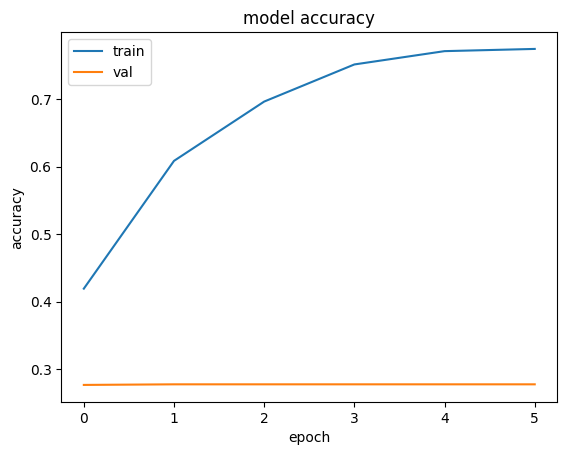

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy1.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss1.png')
plt.show()

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_gen = test_datagen.flow_from_directory(
    "/content/Brain_tumor_dataset/Testing",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1311 images belonging to 4 classes.


In [26]:
model.evaluate(test_gen)
test_loss = evaluation_results[0]
test_acc = evaluation_results[1]
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.1675 - loss: 14.5294 - precision: 0.1680 - recall: 0.1675
Test Accuracy: 0.9176201224327087
Test Loss: 0.22517073154449463


In [27]:
pred_probs=model.predict(test_gen)

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step


In [28]:
from sklearn.metrics import classification_report, confusion_matrix

true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print(classification_report(true_classes, pred_classes, target_names=class_labels))

              precision    recall  f1-score   support

      glioma       0.94      0.92      0.93       300
  meningioma       0.91      0.75      0.83       306
     notumor       0.91      1.00      0.95       405
   pituitary       0.91      0.97      0.94       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



<Axes: >

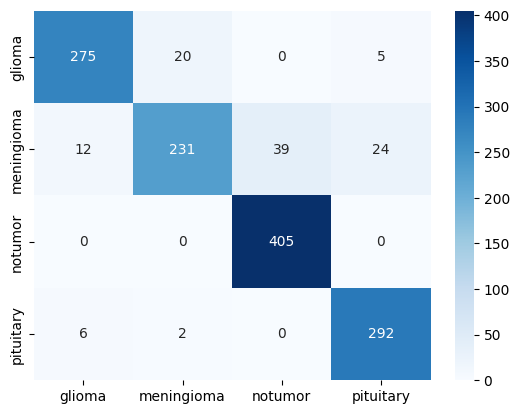

In [29]:
cm=confusion_matrix(true_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

In [30]:
import os
import shutil
plot_dir = "vgg16_plots"
os.makedirs(plot_dir, exist_ok=True)

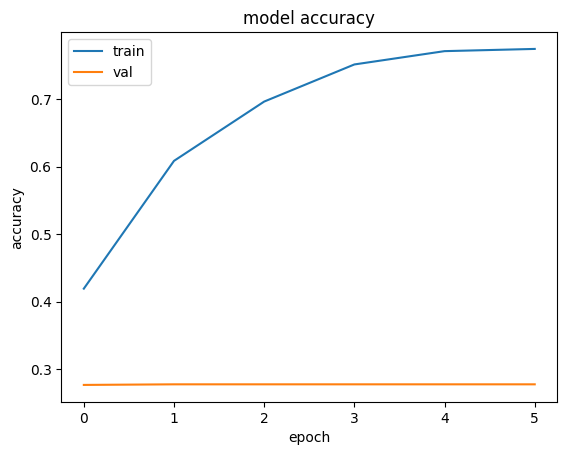

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f"{plot_dir}/accuracy.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

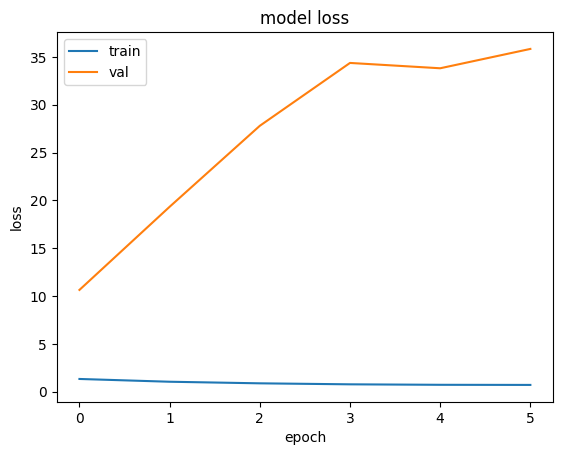

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f"{plot_dir}/loss.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

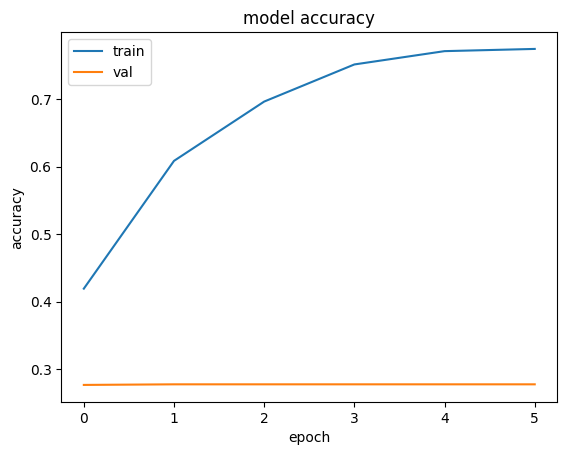

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f"{plot_dir}/accuracy1.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
import shutil

shutil.make_archive("vgg16_plots", 'zip', plot_dir)